# Quantium Data Analytics Virtual Experience Program
## Task 2: Experimentation and uplift testing
The client implemented a trial to 3 selected stores. In this notebook, I examine the effect of this trial to sales and number of customers of these trial stores.
- Measure Calculation - Pick metrics to evaluate the difference before and after the trial
- Select Control Stores - Based on measures, select stores that have the same characteristics as control stores
- Assessment - Hypothesis testing
- Conclussion

## Import Libraries and Select Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import pearsonr, t, ttest_1samp
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

pd.options.mode.chained_assignment = None

We will use the cleaned dataset from Task 1, selecting a few columns only.

In [2]:
# Read in the dataset
trans = pd.read_csv('trans',
                    usecols=['store_nbr', 'card_nbr', 'tot_sales', 'year', 'month'],
                    dtype={'store_nbr':np.object, 'card_nbr':np.object,
                           'tot_sales':np.float64, 'year':np.int64,
                           'month':np.int64})

trans.head()

,store_nbr,card_nbr,tot_sales,year,month
0,1,1000,6.0,2018,10
1,1,1307,6.3,2019,5
2,1,1343,2.9,2019,5
3,2,2373,15.0,2018,8
4,2,2426,13.8,2018,8


From Task 1, we know that our data cover activities from July 2018 to June 2019. First, we need to check if all stores have full 12 months of selling.

In [3]:
# Number of months by store
df = trans[['store_nbr','month']].groupby('store_nbr').\
     agg(lambda x: x.nunique()).reset_index()

# Print out store numbers that have sales in less than 12 months
df[df['month'] < 12]

,store_nbr,month
12,11,2
20,117,11
86,177,11
104,193,3
119,206,2
131,218,11
169,252,2
196,31,2
210,44,11
245,76,1


In [4]:
# Get a list of these stores and exclude them from our dataset
store_missing = df[df['month'] < 12]['store_nbr'].tolist()
full_obs = trans[~trans['store_nbr'].isin(store_missing)]

## Measure Calculation
Now we can create measures as standards to choose control stores. Our measures are total sales and total customers.

In [5]:
# Sum up sale amount by store each month
measure_sum = full_obs.pivot_table(index=['year', 'month', 'store_nbr'],
                                   values=['tot_sales'],
                                   aggfunc='sum')

# Count number of unique customers by store each month
measure_cnt = full_obs.pivot_table(index=['year', 'month', 'store_nbr'],
                                   values=['card_nbr'],
                                   aggfunc=lambda x: x.nunique())

# Merge these two table to get full measure data
measure = measure_sum.join(measure_cnt).reset_index()
measure = measure.rename(columns={'card_nbr':'tot_customers'})

measure.head()

,year,month,store_nbr,tot_sales,tot_customers
0,2018,7,1,191.6,48
1,2018,7,10,841.4,96
2,2018,7,100,941.8,109
3,2018,7,101,847.8,94
4,2018,7,102,725.4,89


## Select Control Stores
Our goal is to find stores that have relatively similar measures to trial stores prior to the trial. In order to do so, we need to assign a score for each store representing how close it is to a certain trial store based on these measures.

This part show how I compute this score, then select control stores and make some visualizations.

### Score Calculation
Let's first extract pre-trial data.

In [6]:
# Pre-trial period: July 2018 to January 2019
pre_trial = measure[(measure['year'] == 2018) |
                    (measure['month'] == 1)]

For each measure, calculation steps are as follows:

1. Get Pearson correlation between the trial store and each of other stores (between 0 and 1, the higher the better)
2. Get Euclidean distance between the trial store and each of other stores (the smaller the better)
3. Use Min-Max scaler to scale the distance to range 0 and 1
4. Calculate weighted sum of the correlation and the distance (I choose 50/50)

The final score is the average of the weighted sum of each measure.

In [7]:
# Get a list of unique store numbers 
unique_store = pre_trial['store_nbr'].unique()
scaler = MinMaxScaler()

Write a function that returns top 5 stores that have the highest score and their corresponding measure scores.

In [8]:
def control_rank(trial, measure, corr_weight):
    """ Return top 5 stores that have highest average score
    reflecting their similarity with the trial store.
    
    Key arguments:
    trial -- the trial store of interest
    measure -- the list of measures of interest
    corr_weight -- the weight ratio to compute the weight average of the measures
    
    """
    # Get a list of other store numbers and creat a blank table
    store_list = unique_store[unique_store != trial]
    score = pd.DataFrame(columns=['store_nbr'])
    
    # Loop over this store number list to compute the correlation and distance
    # between measures of each store and the trial store 
    for x in measure:
        metric_list = [(i, 
                        pearsonr(pre_trial[pre_trial['store_nbr'] == trial][x],
                                           pre_trial[pre_trial['store_nbr'] == i][x])[0],
                        distance.euclidean(pre_trial[pre_trial['store_nbr'] == trial][x],
                                           pre_trial[pre_trial['store_nbr'] == i][x]))
                        for i in store_list]
        
        result = pd.DataFrame(metric_list,
                              columns=['store_nbr', 'correlation_' + x, 'distance_' + x])
        
        # Scale the distance and join it back to the result table
        scaled_distance = scaler.fit_transform(result[['distance_' + x]])
        result = result[['store_nbr', 'correlation_' + x]].join( \
                 pd.DataFrame(scaled_distance, columns=['scaled_distance_' + x]))
        
        # Calculate the weighted score of each measure
        result['score_' + x] = corr_weight*result['correlation_' + x] + \
                               (1 - corr_weight)*(1 - result['scaled_distance_' + x])
        
        # Create score summary table
        score = score.merge(result[['store_nbr', 'score_' + x]],
                            on='store_nbr',
                            how='outer')
    
    # Calculate the average score and return the top 5 stores
    score['avg_score'] = np.average(score.loc[:, score.columns != 'store_nbr'], axis=1)
    return score.nlargest(5, 'avg_score').reset_index(drop=True)

In [9]:
# Apply the function to trial stores
# Measures: total sales, number of customers
# Weights: 0.5
trial_store = ['77', '86', '88']
for s in trial_store:
    print(f'\n-------------------------------------------------')
    print('Top potential control stores for trial store ' + s)
    print(f'\n')
    print(control_rank(s, ['tot_sales', 'tot_customers'], 0.5))


-------------------------------------------------
Top potential control stores for trial store 77


  store_nbr  score_tot_sales  score_tot_customers  avg_score
0       233         0.966855             0.986554   0.976705
1        50         0.935726             0.845147   0.890436
2        41         0.833484             0.909974   0.871729
3       254         0.762320             0.940123   0.851221
4       115         0.853490             0.781557   0.817523

-------------------------------------------------
Top potential control stores for trial store 86


  store_nbr  score_tot_sales  score_tot_customers  avg_score
0       155         0.939397             0.887538   0.913468
1       114         0.860412             0.874360   0.867386
2       138         0.878927             0.785370   0.832148
3        56         0.838884             0.796776   0.817830
4        78         0.765649             0.853879   0.809764

-------------------------------------------------
Top potential c

Based on this result, we have store numbers 233, 155, and 237 as control stores of trial store numbers 77, 86, and 88 respectively.

### Visualization
To make it more visual, let's create another function to graph average sales and average number of customers by store.

In [10]:
def pre_trial_plot(trial, control):
    """ Return two line charts of average monthly sales
    and average monthly number of customers
    
    Key arguments:
    trial -- the trial store of interest
    control -- the corresponding control store
    
    """
    # Name store types
    pre_trial['store_type'] = pre_trial['store_nbr'].apply(lambda x: 'Trial Store' if x == trial
                                                            else 'Control Store' if x == control
                                                            else 'Other Stores')
    
    # Create a pivot table of the means of the number of sales and customers
    # by store number and time
    pivot_df = pre_trial.pivot_table(index=['year', 'month'],
                                     columns='store_type',
                                     values=['tot_sales', 'tot_customers'],
                                     aggfunc='mean')
    
    # Rename its columns
    pivot_df = pivot_df.reindex(columns=[('tot_customers', 'Trial Store'),
                                         ('tot_customers', 'Control Store'),
                                         ('tot_customers', 'Other Stores'),
                                         ('tot_sales', 'Trial Store'),
                                         ('tot_sales', 'Control Store'),
                                         ('tot_sales', 'Other Stores')])
    
    # Plot two line charts
    fig, axes = plt.subplots(2,1, figsize=(10,8))
    fig.suptitle('Pre-Trial Measure Comparison: Trial Store ' + trial \
                 + ' vs. Control Store ' + control,
                 fontsize=16)
    
    pivot_df.plot(ax=axes[0],
                  y='tot_sales',
                  marker='o',
                  linewidth=2,
                  color=['salmon', 'cornflowerblue', 'lightgrey'],
                  sharex=True)   
    axes[0].legend(['Trial Store ' + trial, 'Control Store ' + control, 'Other Stores'],
                   bbox_to_anchor=(1,1),
                   loc='upper left')
    axes[0].set_ylabel('Average Sales')
    axes[0].set_title('Average Monthly Sales')

    pivot_df.plot(ax=axes[1],
                  y='tot_customers',
                  marker='o',
                  linewidth=2,
                  color=['salmon', 'cornflowerblue', 'lightgrey'],
                  legend=None)
    axes[1].set_ylabel('Average Number of Customers')
    axes[1].set_xlabel('Year - Month')
    axes[1].set_title('Average Monthly Number of Customers')

    plt.tight_layout(pad=3)

Apply this function to each pair. 

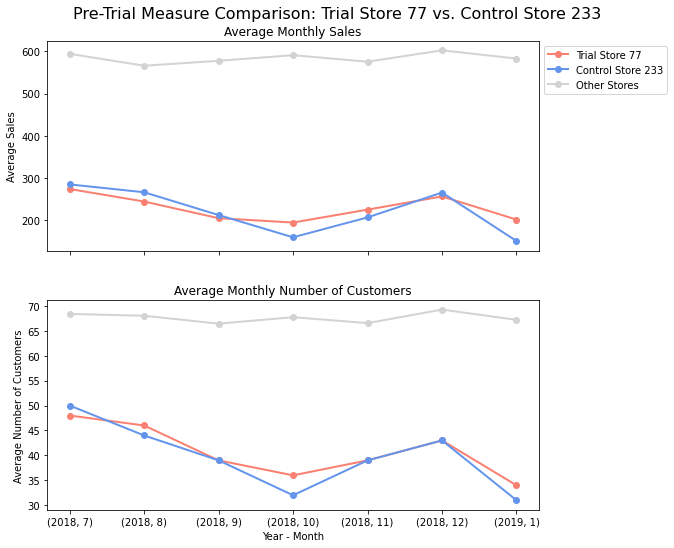

In [11]:
pre_trial_plot('77', '233')

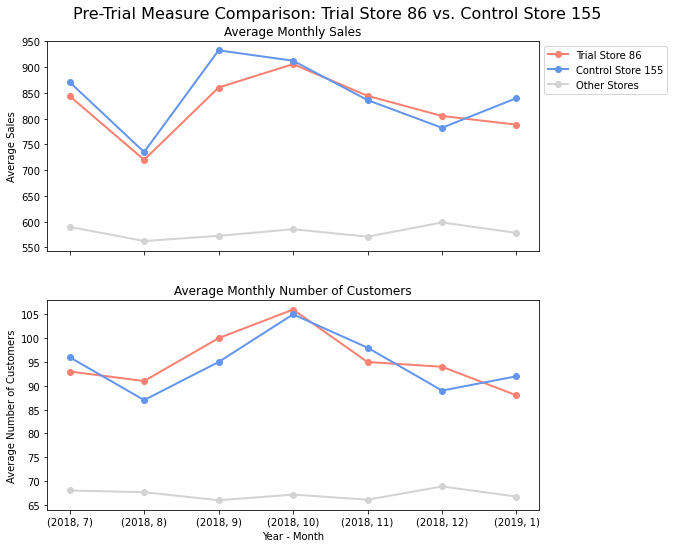

In [12]:
pre_trial_plot('86', '155')

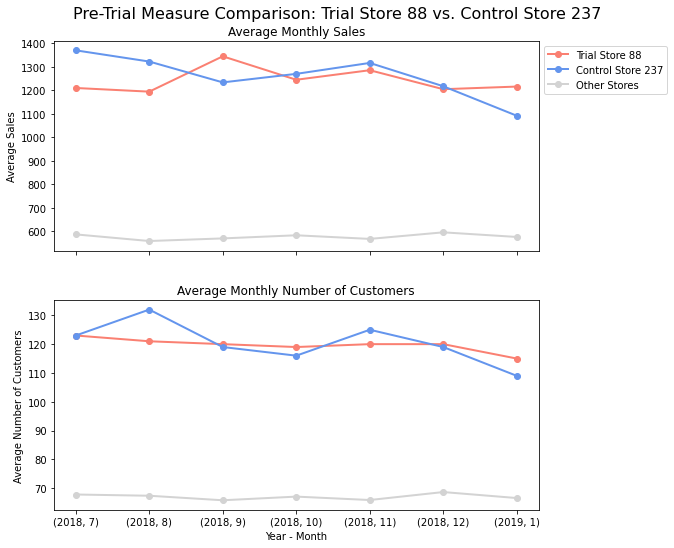

In [13]:
pre_trial_plot('88', '237')

## Assessment
In this part, I employ t-test and t-score to evaluate the difference (in terms of total sales and total customers) between control stores and trial stores during the trial period.

**Null Hypothesis:** There is no difference between trial and control stores prior to the trial period<br>
**Alternative Hypothesis:** There is difference between trial and control stores prior to the trial period

The parameter in this test is the mean difference between trial and control stores before the trial. This mean should be statistically not different from zero (fail to reject the Null Hypothesis). Then use a proper number of degrees of freedom (number of pre-trial months) to construct a t distribution of differences in pre-trial months (the Null Hypothesis distribution) and t-scores of differences in trial months. Under this t distribution, we can determine if these t-scores are statistically different from the mean or not.

<img src="photo/t distribution 7 degrees of freedom.png"><figcaption>Generated from http://www.statdistributions.com, 7 degrees of freedom at a significance level of 0.05</figcaption>

If a t-score > t-statistic (p-value < $\alpha$) then the difference between a trial and its control store in that trial month is greater than 0 at a significance level of 0.05.

In [14]:
def assessment_trial(trial, control, m):
    """ Return a table compare measure values of trial and control store
    and its visualization. Then perform a hypothesis test and determine if
    there is statistically significant difference in measures in trial months.
    
    Key arguments:
    trial -- the trial store number
    control -- the control store number
    m -- the measure of interest
    
    """
    # Calculate a scaling factor to get comparable measures
    trial_sum = pre_trial[pre_trial['store_nbr'] == trial][m].sum()
    control_sum = pre_trial[pre_trial['store_nbr'] == trial][m].sum()
    scaling_factor = trial_sum/control_sum
    
    # Extract the measure from the trial store
    measure_trial = measure[measure['store_nbr'] == trial][['year', 'month', m]].set_index(['year', 'month'])
    measure_trial = measure_trial.rename(columns={m: m + '_' + trial})

    # Extract the measure from the control store
    # then scale this measure by the scaling factor
    measure_control = measure[measure['store_nbr'] == control][['year', 'month', m]].set_index(['year', 'month'])
    measure_control['scaled_' + m + '_' + control] = measure_control[m]*scaling_factor
    measure_control.drop(m, axis=1, inplace=True)

    # Join these values and calculate the difference percentage between them
    assessment = measure_trial.join(measure_control)
    assessment['percentage_diff'] = (assessment[m + '_' + trial] - assessment['scaled_' + m + '_' + control])/ \
                                     assessment[m + '_' + trial]
    
    
    # Print out the table that has trial store measure,
    # control store scaled measure, and the difference percentage
    print(f'Percentage difference between ' + m +' of control store ' + control + ' and trial store ' + trial)
    print(f'\n{assessment}')
    
    # Plot these values on a line chart, highlight the trial period
    assessment.plot(y=[m + '_' + trial, 'scaled_' + m + '_' + control],
                    marker='o', linewidth=2, color=['salmon', 'cornflowerblue'],
                    figsize=(12, 5))
    plt.axvspan(7, 9, color='lemonchiffon', alpha=0.5)
    plt.title('Assessment: Trial Store ' + trial + ' vs. Control Store ' + control,
              fontsize=16)
    plt.legend([m + ' Trial Store ' + trial, 'Scaled ' + m + ' Control Store ' + control,],
               bbox_to_anchor=(1,1), loc='upper left')
    plt.xlabel('Year - Month')
    plt.ylabel(m)
    plt.show()
    
    #Perform a two sample independent t-test (unpaired, having the same population variances)  
    data = assessment['percentage_diff'][:7]
    dfreedom = 7
    t_val, p_val = ttest_1samp(data, 0)

    #Print out t-statistic and p-value
    print('Our hypotheses:\n\t\tH0: diff = 0\n\t\tHa: diff # 0\nResult:')
    print(f't-value({dfreedom})\t{round(t_val*100)/100}\np-value\t\t{round(p_val*100)/100}\n')
    print(f'For a two-tailed t distribution at a significance level of 0.05, we have:\nt-statistic({dfreedom}) = {round(t.ppf(0.975, dfreedom)*100)/100}\n')    
    
    if t_val < t.ppf(0.975, dfreedom):
        print('We fail to reject the null hypothesis of there being no difference\nbetween the trial store and selected control store prior to the trial period.\n')
        print('---------------------------------------------------------------------------------')
        print(f'For a right-tailed t distribution at a significance level of 0.05, we have:\nt-statistic({dfreedom}) = {round(t.ppf(0.95, dfreedom)*100)/100}\n')
        pre_trial_stdev = np.std(data)
        t_scores = [round((i - 0)/pre_trial_stdev*100)/100 for i in assessment['percentage_diff'][7:10]]
        t_data = pd.DataFrame(t_scores, index=['February', 'March', 'April'], columns=['t-score(7)'])
        t_data['p-value'] = t_data['t-score(7)'].apply(lambda x: '< 0.05' if x > t.ppf(0.95, dfreedom) else '> 0.05')
        print(t_data)
    else:
        print('We reject the null hypothesis of there being no difference\nbetween the trial store and selected control store prior to the trial period.')      

### Trial Store 77 vs. Control Store 233

**Measured by Total Sales**

Percentage difference between tot_sales of control store 233 and trial store 77

            tot_sales_77  scaled_tot_sales_233  percentage_diff
year month                                                     
2018 7             273.8                 284.7        -0.039810
     8             244.1                 266.1        -0.090127
     9             204.6                 212.1        -0.036657
     10            194.3                 159.3         0.180134
     11            224.9                 206.5         0.081814
     12            256.2                 265.4        -0.035909
2019 1             201.4                 150.5         0.252731
     2             222.2                 224.3        -0.009451
     3             246.3                 180.6         0.266748
     4             263.5                 144.2         0.452751
     5             272.3                 303.3        -0.113845
     6             249.3                 207.7         0.166867


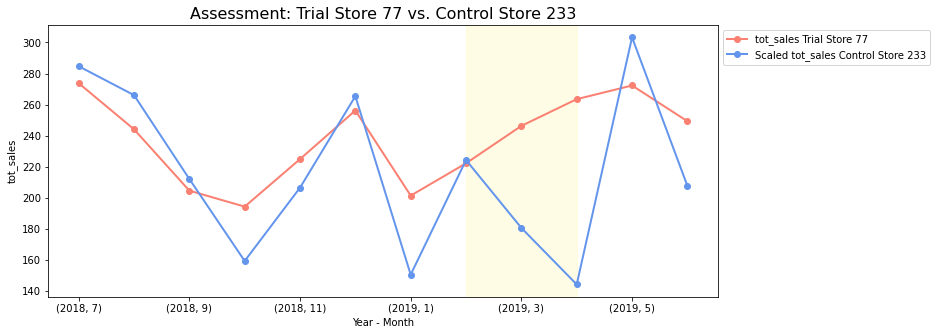

Our hypotheses:
		H0: diff = 0
		Ha: diff # 0
Result:
t-value(7)	0.91
p-value		0.4

For a two-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 2.36

We fail to reject the null hypothesis of there being no difference
between the trial store and selected control store prior to the trial period.

---------------------------------------------------------------------------------
For a right-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 1.89

          t-score(7) p-value
February       -0.08  > 0.05
March           2.22  < 0.05
April           3.76  < 0.05


In [15]:
assessment_trial('77', '233', 'tot_sales')

In trial months March and April, trial store 77 has higher total sales than its control store at a significance level of 0.05.

**Measured by Total of Customers**

Percentage difference between tot_customers of control store 233 and trial store 77

            tot_customers_77  scaled_tot_customers_233  percentage_diff
year month                                                             
2018 7                    48                      50.0        -0.041667
     8                    46                      44.0         0.043478
     9                    39                      39.0         0.000000
     10                   36                      32.0         0.111111
     11                   39                      39.0         0.000000
     12                   43                      43.0         0.000000
2019 1                    34                      31.0         0.088235
     2                    43                      42.0         0.023256
     3                    45                      35.0         0.222222
     4                    47                      27.0         0.425532
     5                    53                      5

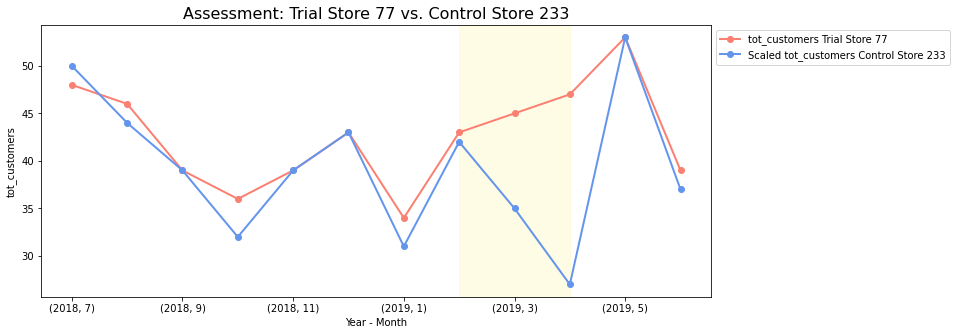

Our hypotheses:
		H0: diff = 0
		Ha: diff # 0
Result:
t-value(7)	1.39
p-value		0.21

For a two-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 2.36

We fail to reject the null hypothesis of there being no difference
between the trial store and selected control store prior to the trial period.

---------------------------------------------------------------------------------
For a right-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 1.89

          t-score(7) p-value
February        0.46  > 0.05
March           4.39  < 0.05
April           8.40  < 0.05


In [16]:
assessment_trial('77', '233', 'tot_customers')

In trial months March and April, trial store 77 has higher total customers than its control store at a significance level of 0.05.

### Trial Store 86 vs. Control Store 155

**Measured by Total Sales**

Percentage difference between tot_sales of control store 155 and trial store 86

            tot_sales_86  scaled_tot_sales_155  percentage_diff
year month                                                     
2018 7            843.80                870.80        -0.031998
     8            720.05                735.10        -0.020901
     9            860.40                932.60        -0.083914
     10           905.80                912.40        -0.007286
     11           844.20                836.00         0.009713
     12           805.20                782.20         0.028564
2019 1            788.20                839.80        -0.065466
     2            888.80                830.00         0.066157
     3            943.60                765.20         0.189063
     4            796.80                810.80        -0.017570
     5            835.00                861.25        -0.031437
     6            746.60                762.40        -0.021163


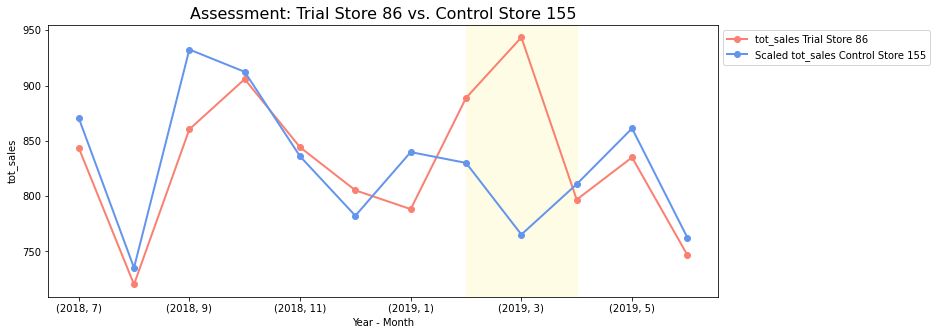

Our hypotheses:
		H0: diff = 0
		Ha: diff # 0
Result:
t-value(7)	-1.62
p-value		0.16

For a two-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 2.36

We fail to reject the null hypothesis of there being no difference
between the trial store and selected control store prior to the trial period.

---------------------------------------------------------------------------------
For a right-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 1.89

          t-score(7) p-value
February        1.79  > 0.05
March           5.12  < 0.05
April          -0.48  > 0.05


In [17]:
assessment_trial('86', '155', 'tot_sales')

In March trial store 86 has higher total sales than its control store at a significance level of 0.05.

**Measured by Total of Customers**

Percentage difference between tot_customers of control store 155 and trial store 86

            tot_customers_86  scaled_tot_customers_155  percentage_diff
year month                                                             
2018 7                    93                      96.0        -0.032258
     8                    91                      87.0         0.043956
     9                   100                      95.0         0.050000
     10                  106                     105.0         0.009434
     11                   95                      98.0        -0.031579
     12                   94                      89.0         0.053191
2019 1                    88                      92.0        -0.045455
     2                   106                      94.0         0.113208
     3                   108                      92.0         0.148148
     4                   100                      95.0         0.050000
     5                   101                     10

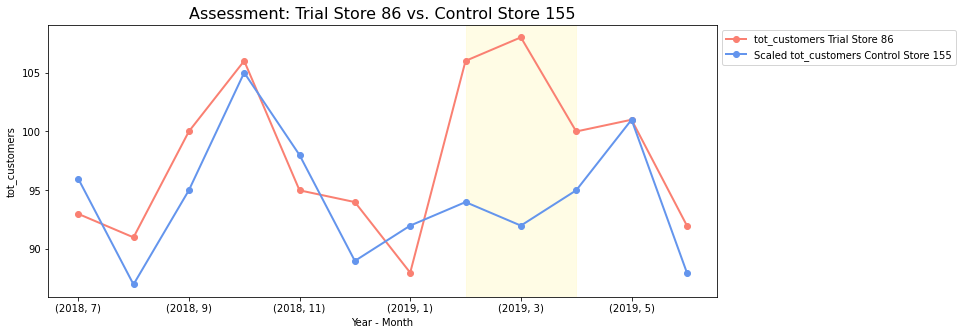

Our hypotheses:
		H0: diff = 0
		Ha: diff # 0
Result:
t-value(7)	0.41
p-value		0.69

For a two-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 2.36

We fail to reject the null hypothesis of there being no difference
between the trial store and selected control store prior to the trial period.

---------------------------------------------------------------------------------
For a right-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 1.89

          t-score(7) p-value
February        2.84  < 0.05
March           3.71  < 0.05
April           1.25  > 0.05


In [18]:
assessment_trial('86', '155', 'tot_customers')

In trial months February and March, trial store 86 has higher total customers than its control store at a significance level of 0.05.

### Trial Store 88 vs. Control Store 237

**Measured by Total Sales**

Percentage difference between tot_sales of control store 237 and trial store 88

            tot_sales_88  scaled_tot_sales_237  percentage_diff
year month                                                     
2018 7           1209.40                1369.6        -0.132462
     8           1193.80                1321.9        -0.107304
     9           1344.20                1233.2         0.082577
     10          1244.40                1269.5        -0.020170
     11          1285.00                1316.0        -0.024125
     12          1204.20                1216.8        -0.010463
2019 1           1215.40                1091.3         0.102106
     2           1313.20                1269.0         0.033658
     3           1431.80                1151.2         0.195977
     4           1281.80                1144.8         0.106881
     5           1219.25                1101.5         0.096576
     6           1235.00                1125.8         0.088421


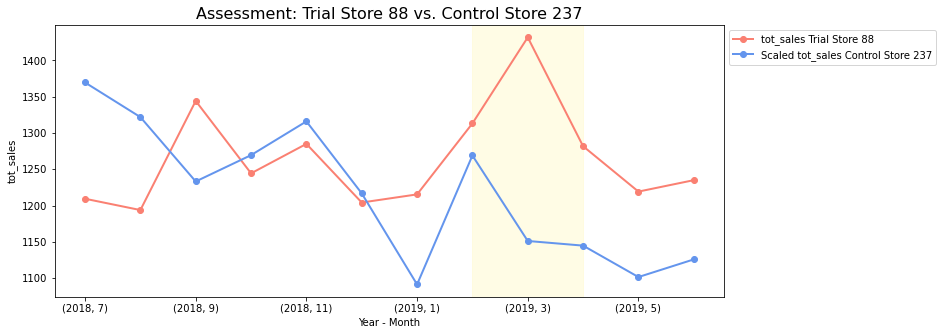

Our hypotheses:
		H0: diff = 0
		Ha: diff # 0
Result:
t-value(7)	-0.48
p-value		0.65

For a two-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 2.36

We fail to reject the null hypothesis of there being no difference
between the trial store and selected control store prior to the trial period.

---------------------------------------------------------------------------------
For a right-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 1.89

          t-score(7) p-value
February        0.42  > 0.05
March           2.43  < 0.05
April           1.32  > 0.05


In [19]:
assessment_trial('88', '237', 'tot_sales')

In March trial store 88 has higher total sales than its control store at a significance level of 0.05.

**Measured by Total of Customers**

Percentage difference between tot_customers of control store 237 and trial store 88

            tot_customers_88  scaled_tot_customers_237  percentage_diff
year month                                                             
2018 7                   123                     123.0         0.000000
     8                   121                     132.0        -0.090909
     9                   120                     119.0         0.008333
     10                  119                     116.0         0.025210
     11                  120                     125.0        -0.041667
     12                  120                     119.0         0.008333
2019 1                   115                     109.0         0.052174
     2                   120                     116.0         0.033333
     3                   129                     115.0         0.108527
     4                   115                     115.0         0.000000
     5                   122                     12

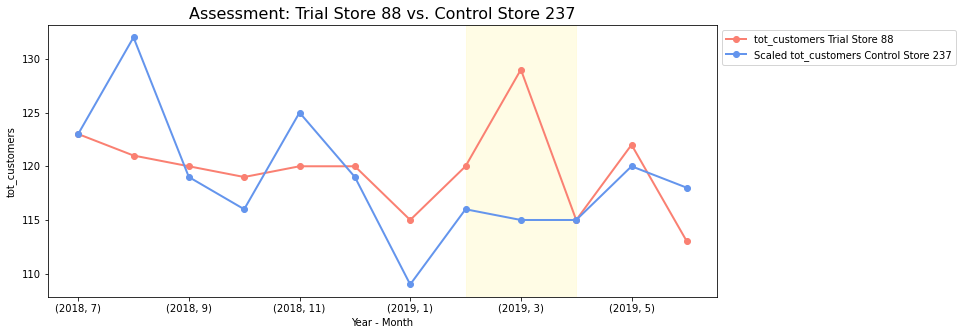

Our hypotheses:
		H0: diff = 0
		Ha: diff # 0
Result:
t-value(7)	-0.31
p-value		0.77

For a two-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 2.36

We fail to reject the null hypothesis of there being no difference
between the trial store and selected control store prior to the trial period.

---------------------------------------------------------------------------------
For a right-tailed t distribution at a significance level of 0.05, we have:
t-statistic(7) = 1.89

          t-score(7) p-value
February        0.77  > 0.05
March           2.49  < 0.05
April           0.00  > 0.05


In [20]:
assessment_trial('88', '237', 'tot_customers')

In March trial store 88 has higher total customers than its control store at a significance level of 0.05.

## Conclusion
| Trial Store | Measure | February | March | April
|:-|:-----|:-----|:----|:---
| 77 | Total sales | No | Yes | Yes
| 77 | Total customers | No | Yes| Yes
| 86 | Total sales | No | Yes | No
| 86 | Total customers | Yes | Yes| No
| 88 | Total sales | No | Yes | No
| 88 | Total customers | No | Yes| No

The table above summarizes our result. The trial has positive effect on sales and number of customers of all trial stores in March. Only store 77 has positive difference in two out of three trial months (March and April) for both measures. Only store 86 has higher number of customers in February.